In [2]:
# ======================================================================
DATETIME = "20241124_090927"  # データファイル名の日時部分 "YYYYMMDD_HHMMSS"
# ======================================================================
import math
import os
from pathlib import Path
import shutil

from astropy import units as u
from matplotlib import pyplot as plt
from neclib import config
from neclib.core import Parameters
from scipy import optimize
import cv2
import numpy as np
import pandas as pd

2024-12-17 16:24:31,458: [ERROR: configuration.py#L228] No telescope specified, using default config....
2024-12-17 16:24:31,459: [INFO: configuration.py#L236] Importing configuration from '/Users/kirby/.necst/config.toml'


In [3]:
# date = pathlib.Path(os.getcwd()).name  # e.g. "20201111_144501"

import pprint
chunk = [{'key': 'data', 'type': 'float', 'value': [79.26461029052734, 25.664697647094727, 100.98291778564453, 25.13111114501953]}, {'key': 'position', 'type': 'string', 'value': 'No0     '}, {'key': 'id', 'type': 'string', 'value': '20241123_121914 '}, {'key': 'time', 'type': 'double', 'value': 1732364431.5172305}, {'key': 'ch', 'type': 'int32', 'value': [0, 0]}, {'key': 'rfreq', 'type': 'double', 'value': [0.0, 0.0]}, {'key': 'ifreq', 'type': 'double', 'value': [0.0, 0.0]}, {'key': 'vlsr', 'type': 'double', 'value': [0.0, 0.0]}, {'key': 'integ', 'type': 'double', 'value': 0.0}]
pprint.pprint(chunk)

[{'key': 'data',
  'type': 'float',
  'value': [79.26461029052734,
            25.664697647094727,
            100.98291778564453,
            25.13111114501953]},
 {'key': 'position', 'type': 'string', 'value': 'No0     '},
 {'key': 'id', 'type': 'string', 'value': '20241123_121914 '},
 {'key': 'time', 'type': 'double', 'value': 1732364431.5172305},
 {'key': 'ch', 'type': 'int32', 'value': [0, 0]},
 {'key': 'rfreq', 'type': 'double', 'value': [0.0, 0.0]},
 {'key': 'ifreq', 'type': 'double', 'value': [0.0, 0.0]},
 {'key': 'vlsr', 'type': 'double', 'value': [0.0, 0.0]},
 {'key': 'integ', 'type': 'double', 'value': 0.0}]


In [4]:
# Get ``pointing_param_path`` from ``config``.
# data_dir = f"/Users/r.yamada/nercst/data/20231220_opticalpointing/metas/"
# pic_dir = f"/Users/r.yamada/nercst/data/20231220_opticalpointing/pics/"
# kisa_file = f"/Users/r.yamada/nercst/data/20231220_opticalpointing/metas/necst_opticalpointing_20231218_135726/pointing_param.toml"
# figs = "/Users/r.yamada/nercST/figs/20231220_opticalpointing/1st_sequence"
# data_dir = "/home/exito/data/operation/optical_pointing/"+date+"/"
# pic_dir = "/home/exito/data/operation/optical_pointing/picture/"+date+"/"
# kisa_file = "/home/exito/ros/src/necst-1p85m2019/lib/kisa.dat"

In [5]:
dbname = f"necst_opticalpointing_{DATETIME}"

data_dir = "data" +"/" + DATETIME
pic_dir = "data" + "/" + DATETIME +"/"
kisa_file = "data" + "/" + DATETIME + "/" + dbname + "/pointing_param.toml"
figs = "figs" + "/" + DATETIME + "/"

Path(figs).mkdir(parents=True, exist_ok=True)

In [6]:
def write_param(filepath, model, a1, a2, a3, b1, b2, b3, g1, c1, c2, d1, d2, e1, e2, unit="deg"):
    with open(filepath, mode="w") as file:
        param = (
            f'[metadata]\n'
            f'model = "{model}"\n'
            f'\n'
            f'[pointing_params]\n'
            f'"a1[{unit}]" = {a1.to(unit).value}\n'
            f'"a2[{unit}]" = {a2.to(unit).value}\n'
            f'"a3[{unit}]" = {a3.to(unit).value}\n'
            f'"b1[{unit}]" = {b1.to(unit).value}\n'
            f'"b2[{unit}]" = {b2.to(unit).value}\n'
            f'"b3[{unit}]" = {b3.to(unit).value}\n'
            f'g1 = {g1}\n'
            f'"c1[{unit}]" = {c1.to(unit).value}\n'
            f'"c2[{unit}]" = {c2.to(unit).value}\n'
            f'"d1[{unit}]" = {d1.to(unit).value}\n'
            f'"d2[{unit}]" = {d2.to(unit).value}\n'
            f'"e1[{unit}]" = {e1.to(unit).value}\n'
            f'"e2[{unit}]" = {e2.to(unit).value}\n'
        )
        file.write(param)
    print(f"======= {filepath!r} =======")
    print(param)

In [7]:
param_before = Parameters.from_file(kisa_file)
def apply_kisa():
        if param_before.model != "omu1p85m":
                raise NotImplementedError(f"This analysis is only for model omu1p85m, not {param_before.model}.")
        # fkisa = open(kisa_file,"r")
        # kisa = fkisa.readlines()
        param_delta = Parameters.from_file(f"{data_dir}/pointing_param_delta.toml")
        # fdkisa = open(f"{data_dir}/pointing_param_delta", "r")
        # dkisa = fdkisa.readlines()
        a1 = param_before.a1 + param_delta.a1
        a2 = param_before.a2 + param_delta.a2
        a3 = param_before.a3 + param_delta.a3
        b1 = param_before.b1 + param_delta.b1
        b2 = param_before.b2 + param_delta.b2
        b3 = param_before.b3 + param_delta.b3
        g1 = param_before.g1 + param_delta.g1
        c1 = param_before.c1 + param_delta.c1
        c2 = param_before.c2 + param_delta.c2
        d1 = param_before.d1 + param_delta.d1
        d2 = param_before.d2 + param_delta.d2
        e1 = param_before.e1 + param_delta.e1
        e2 = param_before.e2 + param_delta.e2
        # fkisa.close()

        # old_kisa_file = f"{data_dir}/pointing_param_before.toml"
        # shutil.copy(kisa_file, old_kisa_file)
        # print("``pointing_param_before.toml`` was created.")

        write_param(f"{data_dir}/pointing_param_after.toml", param_before.model, a1, a2, a3, b1, b2, b3, g1, c1, c2, d1, d2, e1, e2)
        # nkisa = open(kisa_file,"w")
        # param_new = (f'[metadata]\n'
        #              f'model = "{param.model}"\n'
        #              f'\n'
        #              f'[pointing_params]\n'
        #              f'"a1[deg]" = {a1.to("deg").value}\n'
        #              f'"a2[deg]" = {a2.to("deg").value}\n'
        #              f'"a3[deg]" = {a3.to("deg").value}\n'
        #              f'"b1[deg]" = {b1.to("deg").value}\n'
        #              f'"b2[deg]" = {b2.to("deg").value}\n'
        #              f'"b3[deg]" = {b3.to("deg").value}\n'
        #              f'g1 = {g1}\n'
        #              f'"c1[deg]" = {c1.to("deg").value}\n'
        #              f'"c2[deg]" = {c2.to("deg").value}\n'
        #              f'"d1[deg]" = {d1.to("deg").value}\n'
        #              f'"d2[deg]" = {d2.to("deg").value}\n'
        #              f'"e1[deg]" = {e1.to("deg").value}\n'
        #              f'"e2[deg]" = {e2.to("deg").value}\n')
        # nkisa.write(param_new)
        # nkisa.write(str(a1)+"\n")
        # nkisa.write(str(a2)+"\n")
        # nkisa.write(str(a3)+"\n")
        # nkisa.write(str(b1)+"\n")
        # nkisa.write(str(b2)+"\n")
        # nkisa.write(str(b3)+"\n")
        # nkisa.write(str(g1)+"\n")
        # nkisa.write(str(c1)+"\n")
        # nkisa.write(str(c2)+"\n")
        # nkisa.write(str(d1)+"\n")
        # nkisa.write(str(d2)+"\n")    
        # nkisa.write(str(e1)+"\n")
        # nkisa.write(str(e2)+"\n")
        # nkisa.close()

        # new_kisa_file = data_dir + "pointing_param_after.toml"
      #  shutil.copy(f"{data_dir}/pointing_param_after.toml", kisa_file)
       # print("``pointing_param_after.toml`` was created and pointing_param was updated.")
       # print("Data location : " + data_dir)
       # print("======= ``pointing_param_delta.toml`` =======")
       # print(param_delta)
        # print(a1)
        # print(a2)
        # print(a3)
        # print(b1)
        # print(b2)
        # print(b3)
        # print(g1)
        # print(c1)
        # print(c2)
        # print(d1)
        # print(d2)
        # print(e1)
        # print(e2)

In [8]:
def scatter_plot(x, y, xlabel, ylabel,d_rms):
    plt.figure()
    plt.scatter(x, y, s=5)
    if xlabel[0] == 'dAz' and ylabel[0] == 'dEl' or xlabel[0] == 'zansa_dAz' and ylabel[0] == 'zansa_dEl':
        plt.title('%s_vs_%s\nrms = %0.2f[arcsec]'%(xlabel[0], ylabel[0], d_rms))
        plt.axes().set_aspect('equal', 'datalim')
        X, Y = [], []
        for num in np.linspace(-180,180,360):
            r = 5. #[arcsec]
            X.append(r * math.sin(math.radians(num)))
            Y.append(r * math.cos(math.radians(num)))
        plt.plot(X, Y,"r")
    elif xlabel[0] == 'Az' and ylabel[0] == 'El':
        plt.title('%s_vs_%s'%(xlabel[0], ylabel[0]))

    elif xlabel[0] == 'Az':
        plt.title('%s_vs_%s'%(xlabel[0], ylabel[0]))

    elif xlabel[0] == 'El':
        plt.title('%s_vs_%s'%(xlabel[0], ylabel[0]))

    else:
        print('use correct label name')

    plt.xlabel('%s [%s]'%xlabel)
    plt.ylabel('%s [%s]'%ylabel)
    plt.grid()

    plt.savefig(figs + '%s_vs_%s.png'%(xlabel[0], ylabel[0]))

In [9]:
def calc_daz_del():
    filepath = data_dir + f"/necst_opticalpointing_{DATETIME}_meta.csv"
    npix_x = 6000   #number of pixcels
    npix_y = 4000
    sensor_x = 22.3   #sensor size[mm]
    f = 500.   #shoten kyori[mm]

    metadata = pd.read_csv(filepath)
    fl = metadata.file
    Az = metadata.cap_az
    El = metadata.cap_el
    
   # print(fl, _Az)
    pix_x = []
    pix_y = []
    figli = []
    starp = []
    for i,fl1 in enumerate(fl):
        try:
            img = cv2.imread(pic_dir+fl1+".JPG", cv2.IMREAD_GRAYSCALE)
            print("calculated dAz dEl : "+pic_dir+fl1+".JPG")
            img = np.flipud(img)
            ret, nimg = cv2.threshold(img, 50, 255, cv2.THRESH_BINARY)  # 点源検出
            contours, hierarchy = cv2.findContours(nimg, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)  # 点源検出
            stars = []
            areas = []
            for cnt in contours:
                M = cv2.moments(cnt)
                if M['m00'] != 0:
                    cx = int(M['m10']/M['m00'])
                    cy = int(M['m01']/M['m00'])
                    stars.append(np.array([[cx,cy]], dtype='int32'))
                else:
                    stars.append(np.array([cnt[0][0]], dtype='int32'))
                areas.append(cv2.contourArea(cnt))

            areasarr = np.array(areas)
            idx = areasarr.argmax()
            plt.imshow(np.flipud(cv2.imread(pic_dir+fl1+".JPG")), vmin=0, vmax=256)
            plt.xlim(0, npix_x)
            plt.ylim(0, npix_y)
            plt.plot(stars[idx][0][0], stars[idx][0][1], marker='+', ms=8, alpha=0.7, color="red", mew=0.2)
            plt.title("Az : "+str(Az[i])+" EL : "+str(El[i]))
            plt.savefig(figs+fl1+'.mark.png', dpi=300)
            plt.show()
            plt.close()
            pix_x.append(stars[idx][0][0])
            pix_y.append(stars[idx][0][1])
        except Exception as e:
            pix_x.append(np.nan)
            pix_y.append(np.nan)
            print(f"ERROR : can not find star position\n{e}")
            print(fl1)
    

    pix = np.array([pix_x, pix_y]).T

    dpix_x = (pix[:,0] - npix_x//2)
    dpix_y = (pix[:,1] - npix_y//2)

    theta_x = 2 * np.degrees(np.arctan(sensor_x / (2*f)))   #[degree]

    theta_x_pix = (theta_x / npix_x) * 3600.   #[arcsec]

    #---pixcel --> pix_x_to_arcsec
    d_x = dpix_x * theta_x_pix   #[arcsec]
    d_y = dpix_y * theta_x_pix   #[arcsec]

    d_x_sigma = np.nanstd(d_x)
    d_y_sigma = np.nanstd(d_y)

    d_x_rms = np.sqrt(np.nansum(d_x**2)/len(d_x))
    d_y_rms = np.sqrt(np.nansum(d_y**2)/len(d_y))

    d_rms = np.sqrt(d_x_rms**2 + d_y_rms**2)
    d_sigma = np.sqrt(d_x_sigma**2 + d_y_sigma**2)

    print('rms = %0.2f [arcsec]'%d_rms)
    print('sigma = %0.2f [arcsec]'%d_sigma)

    p_array = np.array([Az, El, d_x, d_y]).T
    np.savetxt(data_dir + 'Az_El_dAz_dEl.dat', p_array, delimiter=', ')
    scatter_plot(Az, El, ('Az', 'degree'), ('El', 'degree'), d_rms)
    scatter_plot(Az, d_x, ('Az', 'degree'), ('dAz', 'arcsec'), d_rms)
    scatter_plot(Az, d_y, ('Az', 'degree'), ('dEl', 'arcsec'), d_rms)
    scatter_plot(El, d_x, ('El', 'degree'), ('dAz', 'arcsec'), d_rms)
    scatter_plot(El, d_y, ('El', 'degree'), ('dEl', 'arcsec'), d_rms)
    scatter_plot(d_x, d_y, ('dAz', 'arcsec'), ('dEl', 'arcsec'), d_rms)
    
    return np.array([(_az, _el, _dx, _dy) for _az, _el, _dx, _dy in zip(Az, El, d_x, d_y)], dtype=[('az', float), ('el', float), ('dx', float), ('dy', float)])


calculated dAz dEl : data/20241124_090927/20241124_090927No0.JPG


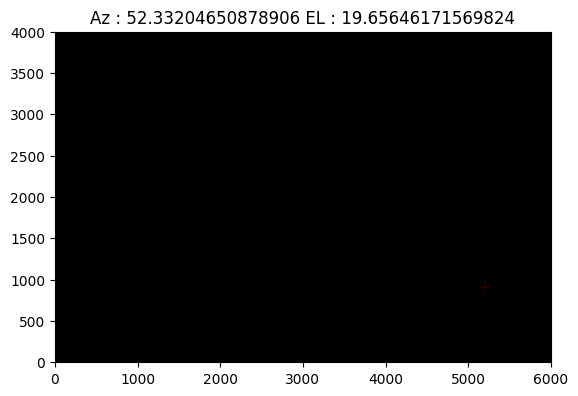

calculated dAz dEl : data/20241124_090927/20241124_090927No1.JPG


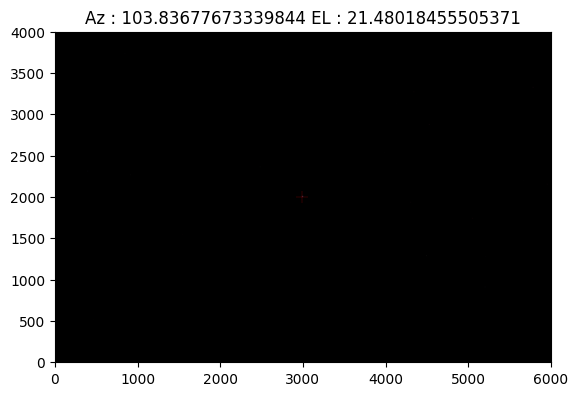

calculated dAz dEl : data/20241124_090927/20241124_090927No2.JPG


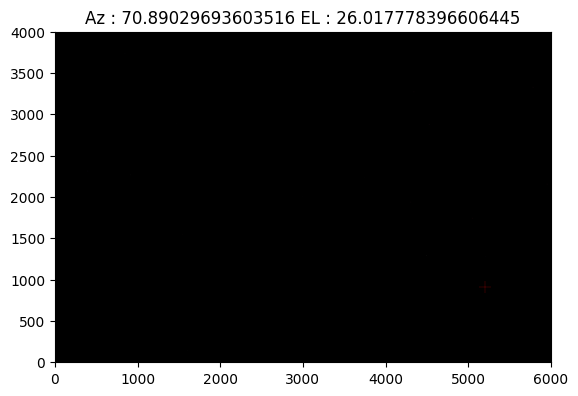

calculated dAz dEl : data/20241124_090927/20241124_090927No3.JPG


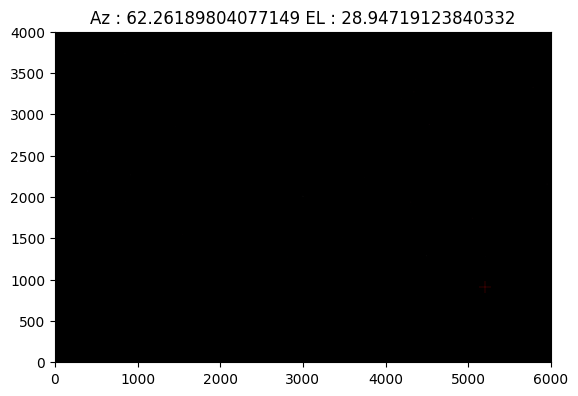

calculated dAz dEl : data/20241124_090927/20241124_090927No4.JPG


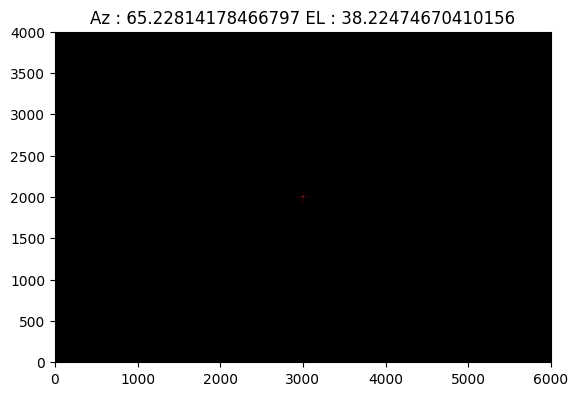

calculated dAz dEl : data/20241124_090927/20241124_090927No5.JPG


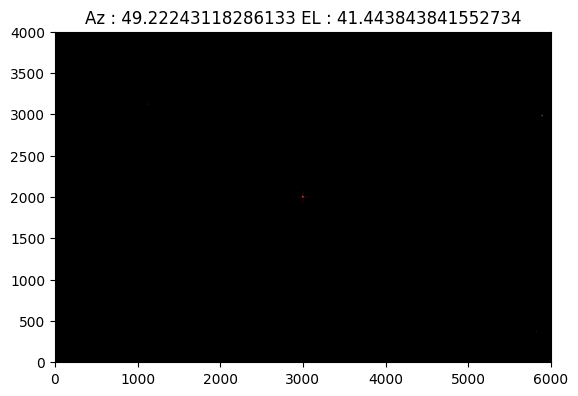

calculated dAz dEl : data/20241124_090927/20241124_090927No6.JPG


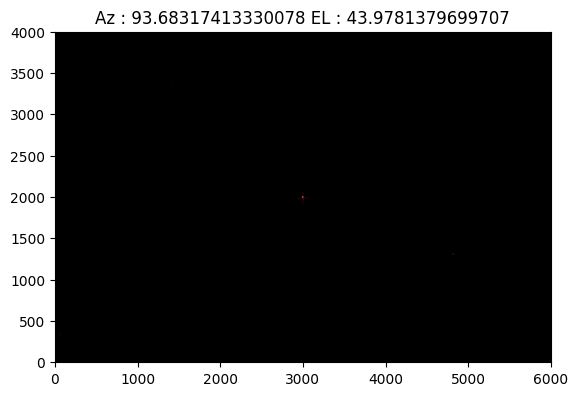

calculated dAz dEl : data/20241124_090927/20241124_090927No7.JPG


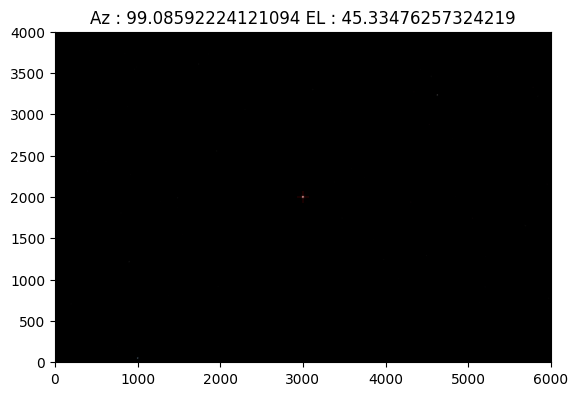

calculated dAz dEl : data/20241124_090927/20241124_090927No8.JPG


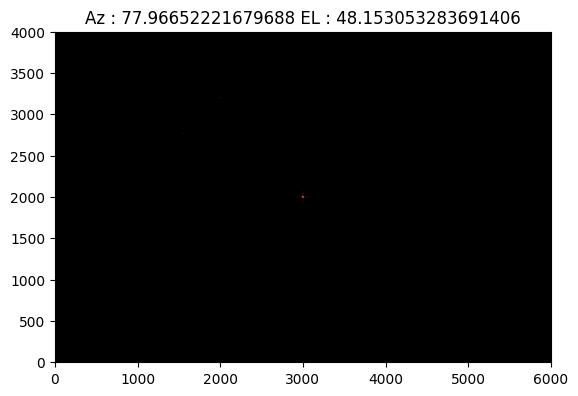

calculated dAz dEl : data/20241124_090927/20241124_090927No9.JPG


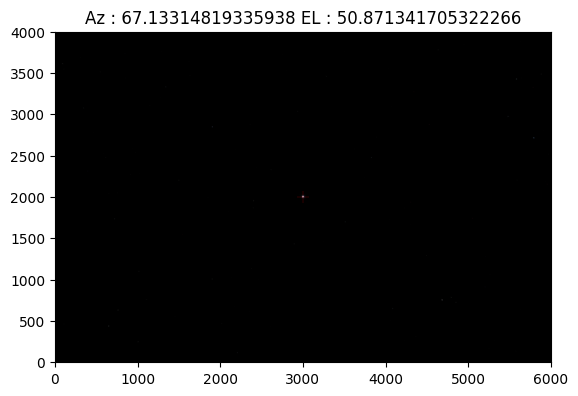

calculated dAz dEl : data/20241124_090927/20241124_090927No10.JPG


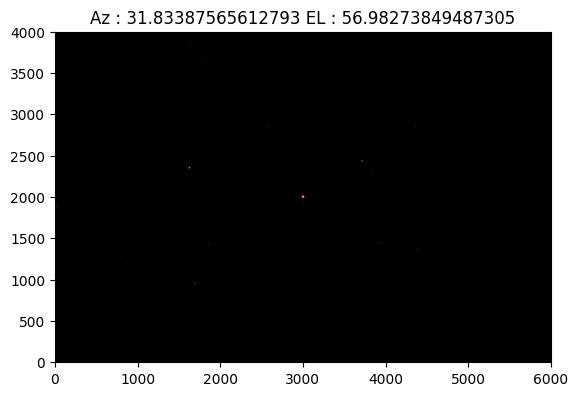

calculated dAz dEl : data/20241124_090927/20241124_090927No11.JPG


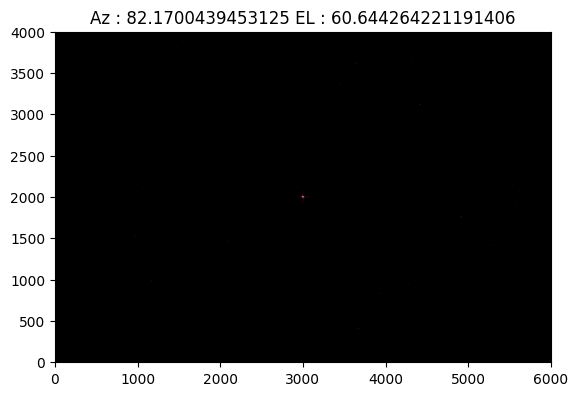

calculated dAz dEl : data/20241124_090927/20241124_090927No12.JPG


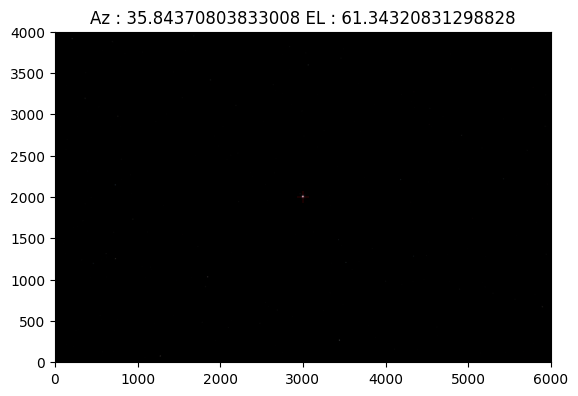

calculated dAz dEl : data/20241124_090927/20241124_090927No13.JPG


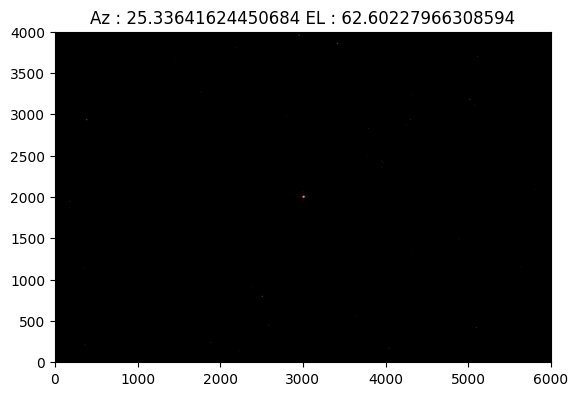

calculated dAz dEl : data/20241124_090927/20241124_090927No14.JPG


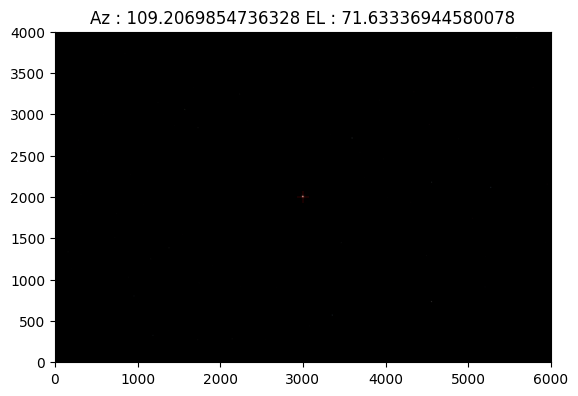

calculated dAz dEl : data/20241124_090927/20241124_090927No15.JPG


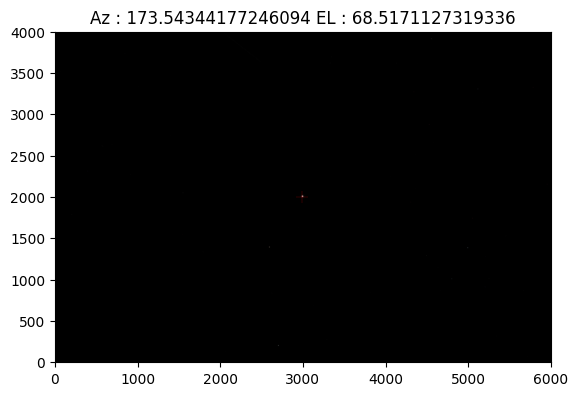

calculated dAz dEl : data/20241124_090927/20241124_090927No16.JPG


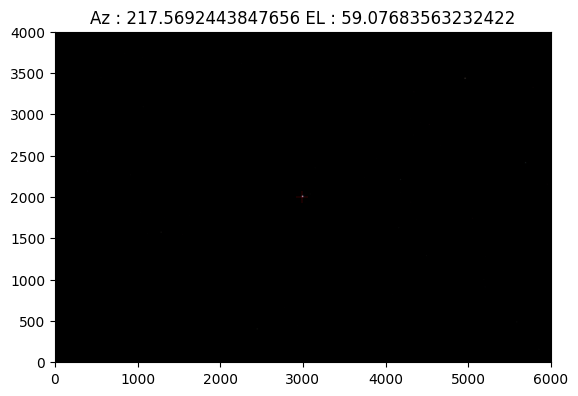

calculated dAz dEl : data/20241124_090927/20241124_090927No17.JPG


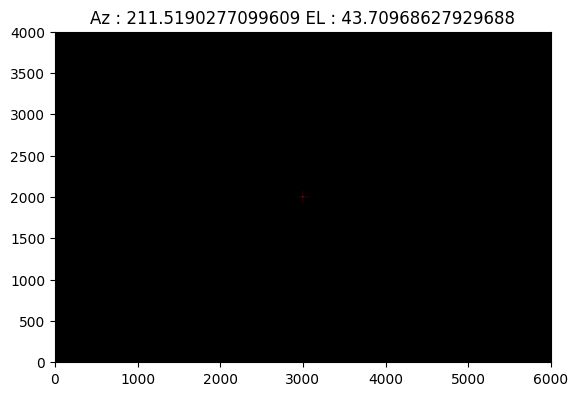

calculated dAz dEl : data/20241124_090927/20241124_090927No18.JPG


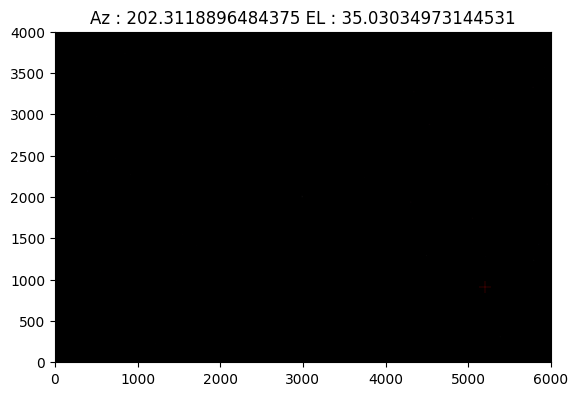

calculated dAz dEl : data/20241124_090927/20241124_090927No19.JPG


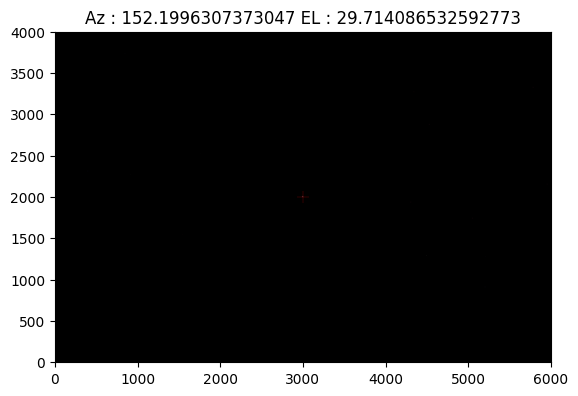

calculated dAz dEl : data/20241124_090927/20241124_090927No20.JPG


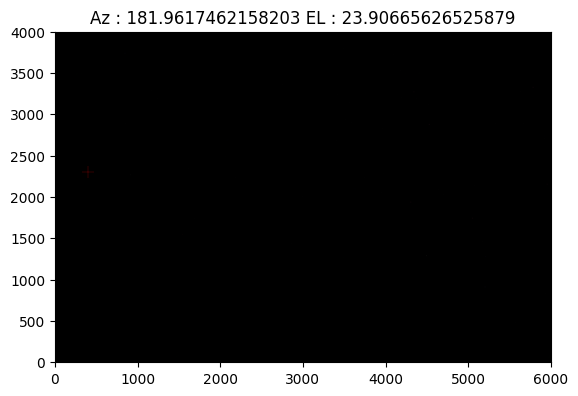

calculated dAz dEl : data/20241124_090927/20241124_090927No21.JPG


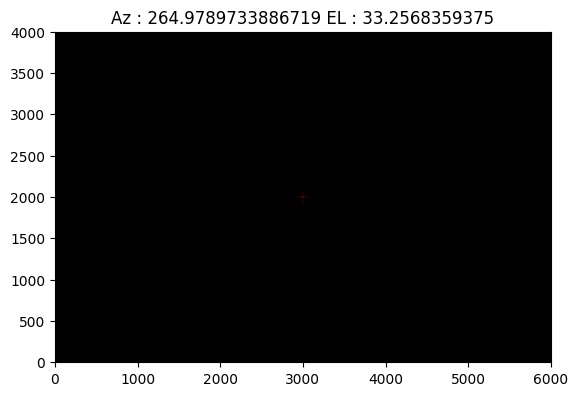

calculated dAz dEl : data/20241124_090927/20241124_090927No22.JPG


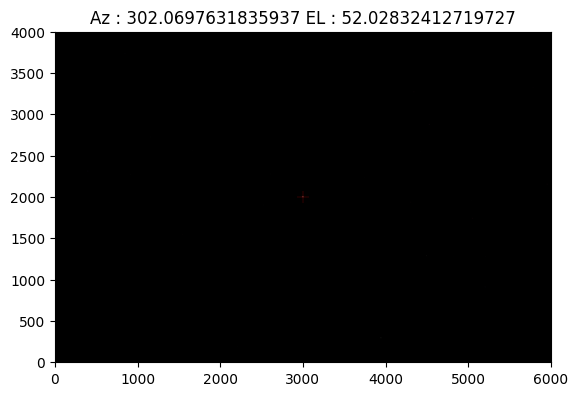

calculated dAz dEl : data/20241124_090927/20241124_090927No23.JPG


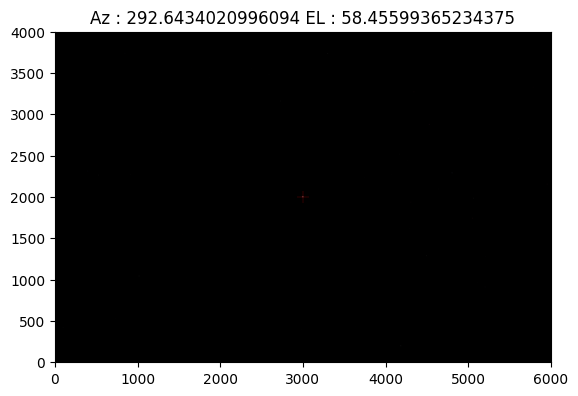

calculated dAz dEl : data/20241124_090927/20241124_090927No24.JPG


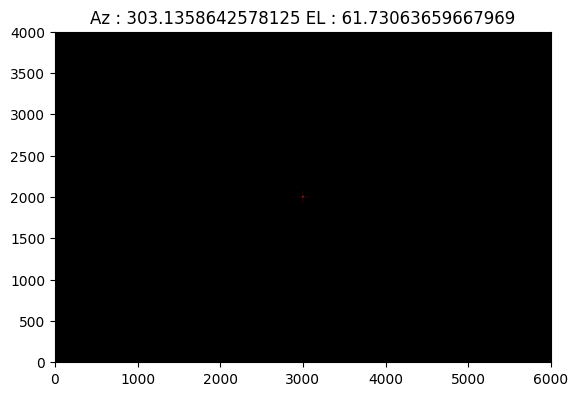

calculated dAz dEl : data/20241124_090927/20241124_090927No25.JPG


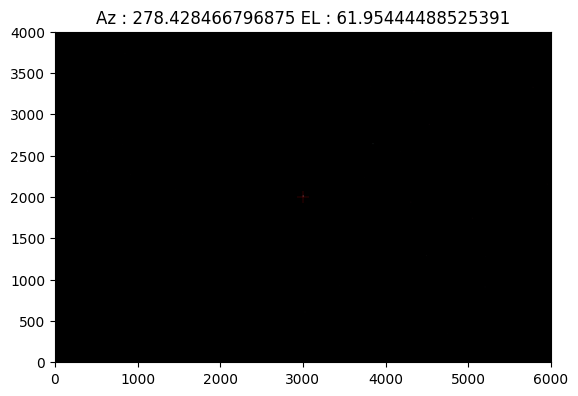

calculated dAz dEl : data/20241124_090927/20241124_090927No26.JPG


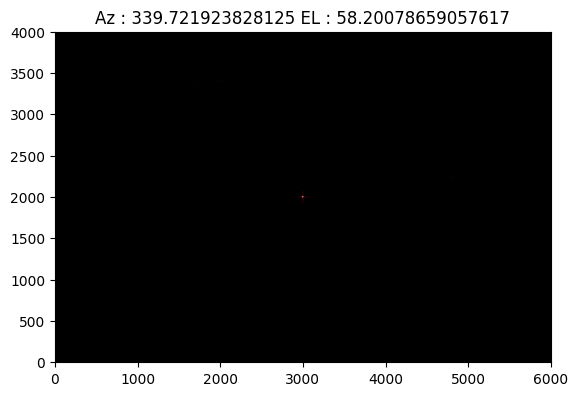

calculated dAz dEl : data/20241124_090927/20241124_090927No27.JPG


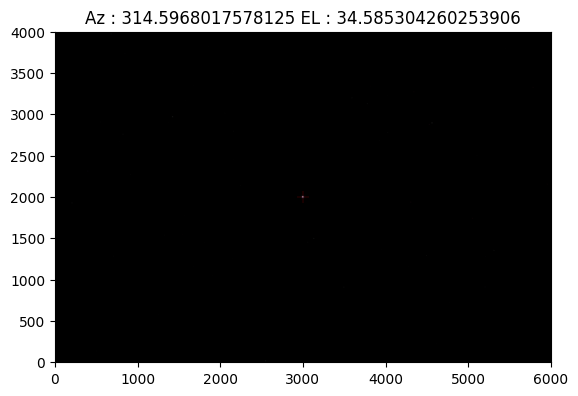

calculated dAz dEl : data/20241124_090927/20241124_090927No28.JPG


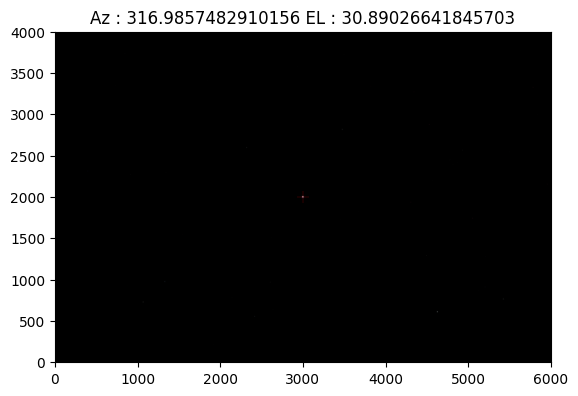

calculated dAz dEl : data/20241124_090927/20241124_090927No29.JPG


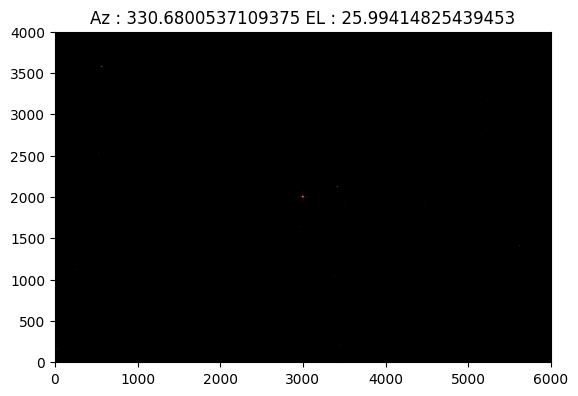

rms = 1559.56 [arcsec]
sigma = 1512.99 [arcsec]


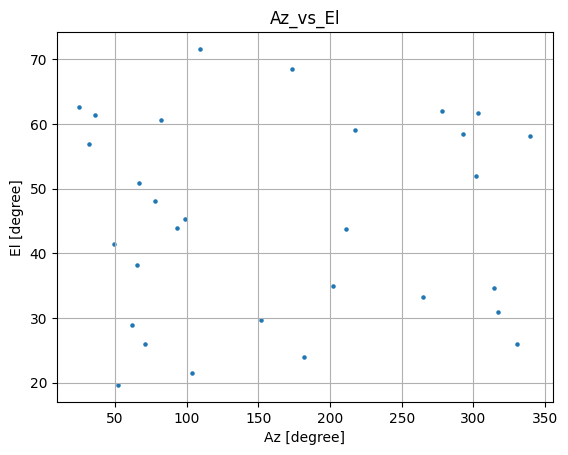

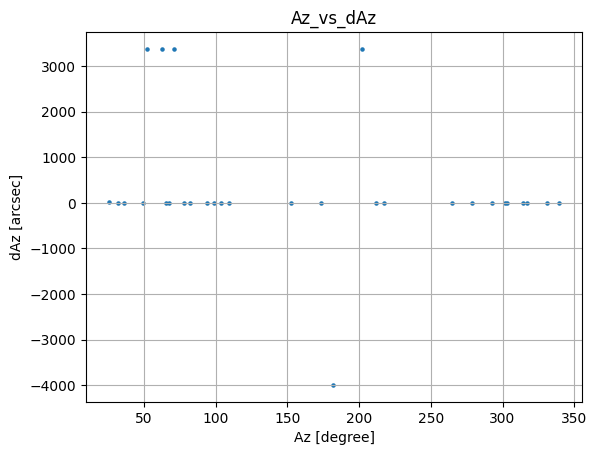

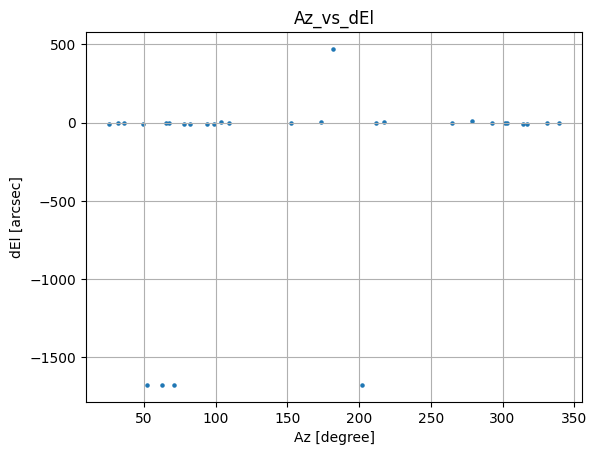

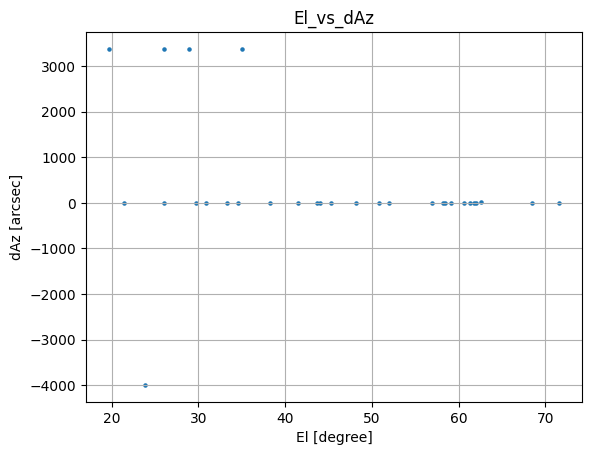

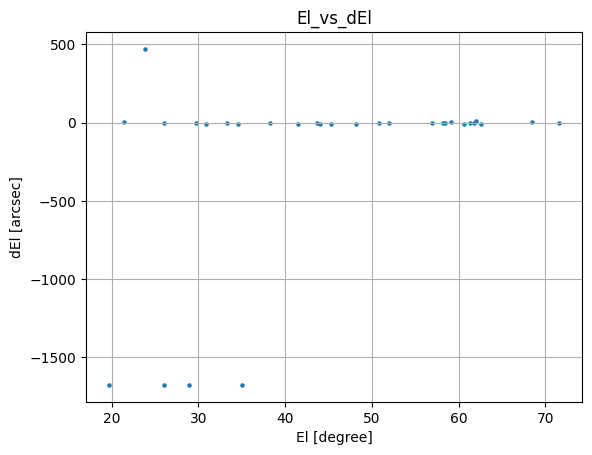

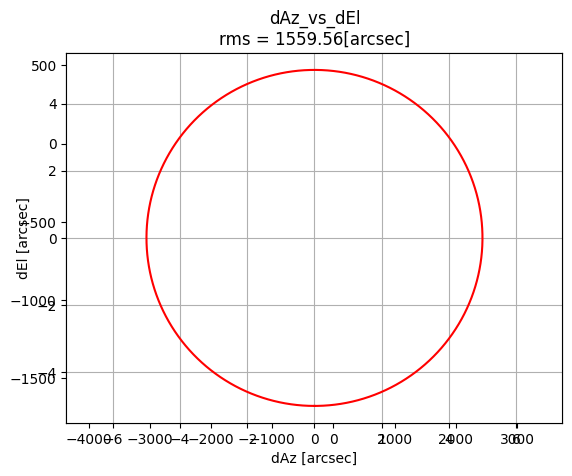

In [10]:
results = calc_daz_del()

In [11]:
results

array([( 52.33204651, 19.65646172,  3.37562412e+03, -1.67554821e+03),
       (103.83677673, 21.48018456, -7.66490491e+00,  1.53298098e+00),
       ( 70.89029694, 26.0177784 ,  3.37562412e+03, -1.67554821e+03),
       ( 62.26189804, 28.94719124,  3.37562412e+03, -1.67554821e+03),
       ( 65.22814178, 38.2247467 , -4.59894294e+00, -1.53298098e+00),
       ( 49.22243118, 41.44384384, -4.59894294e+00, -6.13192393e+00),
       ( 93.68317413, 43.97813797, -4.59894294e+00, -1.07308669e+01),
       ( 99.08592224, 45.33476257, -1.53298098e+00, -9.19788589e+00),
       ( 77.96652222, 48.15305328, -3.06596196e+00, -7.66490491e+00),
       ( 67.13314819, 50.87134171,  0.00000000e+00, -3.06596196e+00),
       ( 31.83387566, 56.98273849,  0.00000000e+00, -4.59894294e+00),
       ( 82.17004395, 60.64426422, -1.53298098e+00, -6.13192393e+00),
       ( 35.84370804, 61.34320831, -3.06596196e+00, -1.53298098e+00),
       ( 25.33641624, 62.60227966,  1.07308669e+01, -6.13192393e+00),
       (109.20698547

In [12]:
len(results)

30

In [13]:
# いらない点を除去
bad_data_mask1 = abs(results['dy']) < 500
bad_data_mask2 = abs(results['dx']) < 500
bad_data_mask1
#bad_data_mask = results['dy'] <1000 
#

array([False,  True, False, False,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
       False,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True])

In [14]:
results2 = results[bad_data_mask1]
bad_data_mask2 = abs(results2['dx']) < 500
results2 = results2[bad_data_mask2]

In [19]:
np.savetxt(data_dir + 'Az_El_dAz_dEl.csv', results2, delimiter=', ')

In [16]:
len(results2)

25

In [32]:
# rms の計算
dx_sigma = np.nanstd(results2["dx"])
dx_rms = np.sqrt(np.nanmean(results2["dx"] ** 2))
dy_sigma = np.nanstd(results2["dy"])
dy_rms = np.sqrt(np.nanmean(results2["dy"] ** 2))
d_sigma = np.sqrt(dx_sigma ** 2 + dy_sigma ** 2)
d_rms = np.sqrt(dx_rms ** 2 + dy_rms ** 2)

print(f"sigma = {d_sigma:.2f} arcsec")
print(f"rms = {d_rms:.2f} arcsec")

dx_mean = results2["dx"].mean()
dy_mean = results2["dy"].mean()
print(f"dx_mean = {dx_mean:.2f} arcsec")
print(f"dy_mean = {dy_mean:.2f} arcsec")
dx_mean_deg = dx_mean / 3600
dy_mean_deg = dy_mean / 3600

sigma = 5.59 arcsec
rms = 7.49 arcsec
dx_mean = -3.43 arcsec
dy_mean = -3.62 arcsec


In [17]:
def f_az2(X, a1, a2, a3, b1, b2, b3, g1):
    _az, _el = X
    az = _az * np.pi / 180  # deg -> rad
    el = _el * np.pi / 180  # deg -> rad
    # return np.cos(el) * ((a1 * np.tan(el)) + (a2 / np.cos(el)) + a3 + (b1 * np.sin(az) * np.sin(el) - b2 * np.cos(az) * np.sin(el)) / np.cos(el))
    return (a1 * np.sin(el) + a2 + a3 * np.cos(el) + b1 * np.sin(az) * np.sin(el) - b2 * np.cos(az) * np.sin(el)) / 1  # np.cos(el)  # deg

def f_el2(X, a1, a2, a3, b1, b2, b3, g1):
    _az, _el = X
    az = _az * np.pi / 180  # deg -> rad
    return b1 * np.cos(az) + b2 * np.sin(az) + b3 + g1 * _el  # deg

def eval_func(p, az, el, _dx):
    dx = _dx / 3600  # arcsec -> deg
    results_dx = f_az2([az, el], *p)
    return (dx - results_dx) ** 2

def eval_func2(p, az, el, _dy):
    dy = _dy / 3600  # arcsec -> deg
    results_dy = f_el2([az, el],*p)
    return (dy - results_dy) ** 2

def eval_func3(p, az, el, _dx, _dy):
    dx = _dx / 3600  # arcsec -> deg
    dy = _dy / 3600  # arcsec -> deg
    results_dx = f_az2([az, el], *p)
    results_dy = f_el2([az, el], *p)
    return (dx - results_dx) ** 2 + (dy - results_dy) ** 2

In [19]:
pp1 = optimize.least_squares(eval_func, x0=[0,dx_mean_deg,0,0,0,dy_mean_deg,0], args=(results2['az'], results2['el'], results2['dx']))
pp2 = optimize.least_squares(eval_func2, x0=[0,dx_mean_deg,0,0,0,dy_mean_deg,0], args=(results2['az'], results2['el'], results2['dy']))
print(pp1.x)
print(pp2.x)
print(pp1.x * 3600)
print(pp2.x * 3600)

[-0.00032057  0.00081004 -0.00233072  0.00052456 -0.0014207  -0.00100495
  0.        ]
[ 0.00000000e+00 -2.67307551e-03  7.20801770e-04 -8.46824656e-04
 -6.76976282e-04 -1.25821201e-03  1.40381397e-05]
[-1.15403779  2.91615458 -8.39060297  1.88840384 -5.11453174 -3.61783512
  0.        ]
[ 0.         -9.62307182  2.59488637 -3.04856876 -2.43711462 -4.52956323
  0.0505373 ]


In [20]:
pp = list(pp1.x[0:3])+list(pp2.x[3:7])
print(pp)

[-0.0003205660524998324, 0.0008100429388800843, -0.0023307230466096535, -0.0008468246555121489, -0.0006769762822630524, -0.0012582120087462963, 1.403813973331422e-05]


In [21]:
pp3 = optimize.least_squares(eval_func3, x0=pp, args=(results2['az'], results2['el'], results2['dx'], results2['dy']))
print(pp3.x)
print(pp3.x * 3600)

[ 1.87226653e-04  7.71936013e-04 -2.80358804e-03 -4.11491839e-04
 -8.45770550e-04 -1.08544774e-03  7.41401136e-06]
[  0.67401595   2.77896965 -10.09291694  -1.48137062  -3.04477398
  -3.90761185   0.02669044]


In [22]:
bestfit_dx = f_az2([results2["az"],results2["el"]], *pp3.x) * 3600
bestfit_dy = f_el2([results2["az"],results2["el"]], *pp3.x) * 3600

In [23]:
error_dx = results2['dx'] - bestfit_dx  # arcsec
error_dy = results2['dy'] - bestfit_dy  # arcsec

bestfit_dx_sigma = np.nanstd(error_dx)  # arcsec
bestfit_dy_sigma = np.nanstd(error_dy)  # arcsec
bestfit_d_sigma = np.sqrt(bestfit_dx_sigma**2 + bestfit_dy_sigma**2)  # arcsec

print(f"bestfit_sigma = {bestfit_d_sigma:.2f} arcsec")

bestfit_sigma = 5.17 arcsec


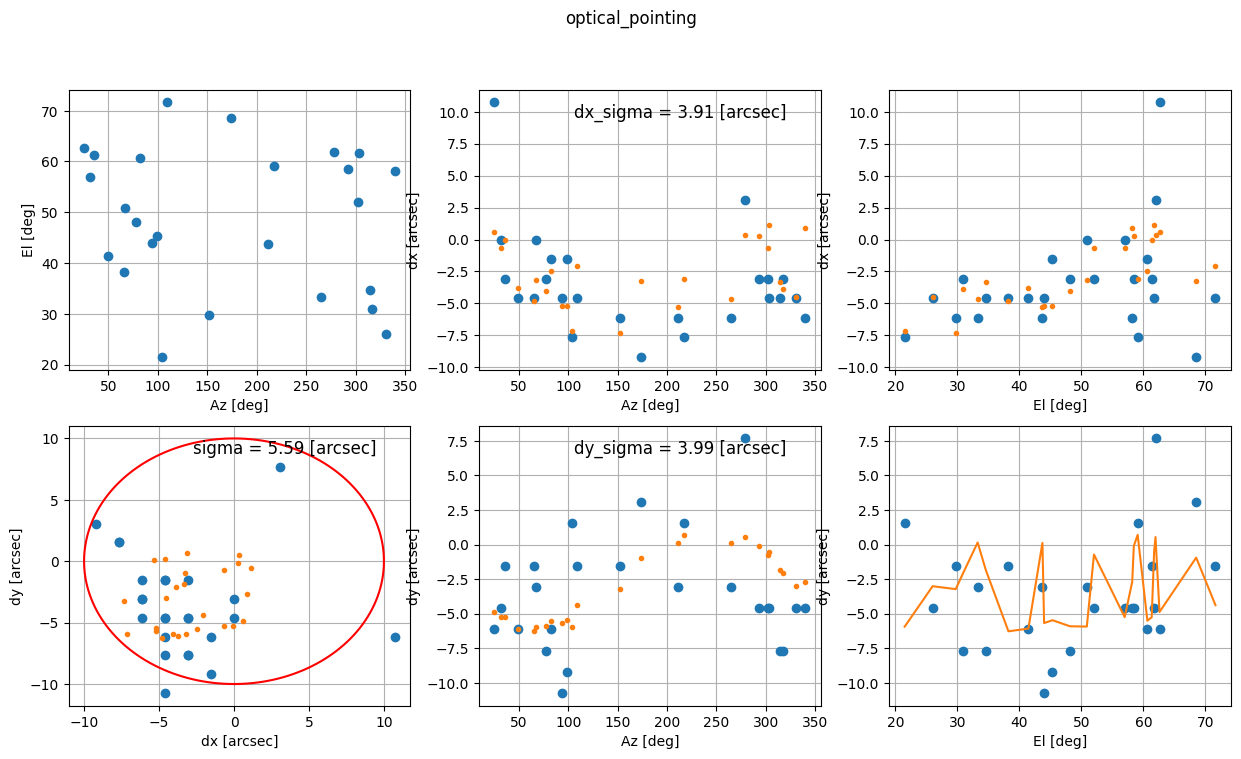

In [31]:
fig = plt.figure(figsize=[15,8])
ax = [fig.add_subplot(2,3,i) for i in range(1,7)]

ax[0].plot(results2['az'], results2['el'], 'o')
ax[0].set_xlabel('Az [deg]')
ax[0].set_ylabel('El [deg]')

ax[1].plot(results2['az'], results2['dx'], 'o')
ind1=np.argsort(results2['az'])
ax[1].plot(results2['az'][ind1], bestfit_dx[ind1], '.')
ax[1].set_xlabel('Az [deg]')
ax[1].set_ylabel('dx [arcsec]')
ax[1].text(0.9, 0.95, 'dx_sigma = %0.2f [arcsec]'%dx_sigma, size=12, ha='right', va='top', transform=ax[1].transAxes,)

ax[2].plot(results2['el'], results2['dx'], 'o')
ind2=np.argsort(results2['el'])
ax[2].plot(results2['el'][ind2], bestfit_dx[ind2], '.')
ax[2].set_xlabel('El [deg]')
ax[2].set_ylabel('dx [arcsec]')

ax[3].plot(results2['dx'], results2['dy'], 'o')
ax[3].plot(bestfit_dx, bestfit_dy, '.')
ax[3].set_xlabel('dx [arcsec]')
ax[3].set_ylabel('dy [arcsec]')
ax[3].text(0.9, 0.95, 'sigma = %0.2f [arcsec]'%d_sigma, size=12, ha='right', va='top', transform=ax[3].transAxes,)

X, Y = [], []
for num in np.linspace(-180,180,360):
    r = 10. #[arcsec]
    X.append(r * math.sin(math.radians(num)))
    Y.append(r * math.cos(math.radians(num)))
ax[3].plot(X, Y,"r")

ax[4].plot(results2['az'], results2['dy'], 'o')
ax[4].plot(results2['az'][ind1], bestfit_dy[ind1], '.')
ax[4].set_xlabel('Az [deg]')
ax[4].set_ylabel('dy [arcsec]')
ax[4].text(0.9, 0.95, 'dy_sigma = %0.2f [arcsec]'%dy_sigma, size=12, ha='right', va='top', transform=ax[4].transAxes,)

ax[5].plot(results2['el'], results2['dy'], 'o')
ax[5].plot(results2['el'][ind2], bestfit_dy[ind2], '-')
ax[5].set_xlabel('El [deg]')
ax[5].set_ylabel('dy [arcsec]')

[a.grid(True) for a in ax]

fig.suptitle("optical_pointing")
fig.savefig(figs + "optical_pointing_results" + ".png")

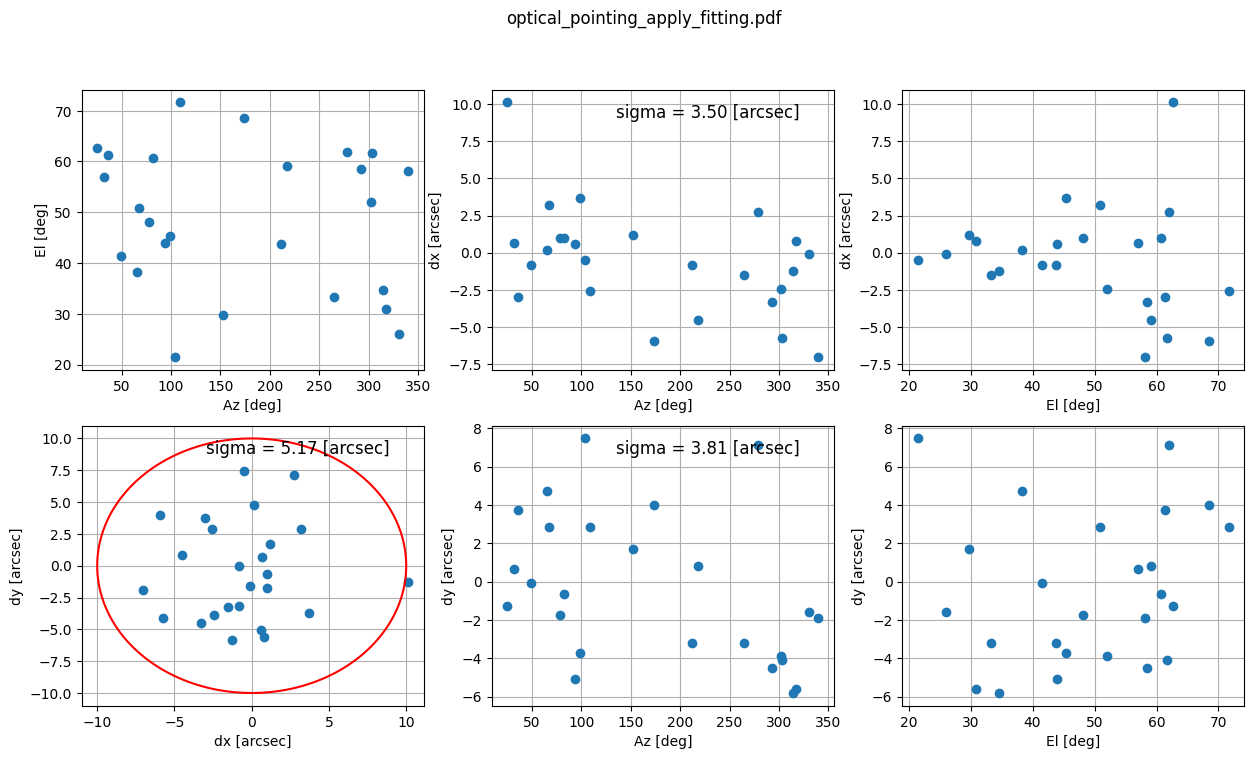

In [25]:
fig = plt.figure(figsize=[15,8])
ax = [fig.add_subplot(2,3,i) for i in range(1,7)]

ax[0].plot(results2['az'], results2['el'], 'o')
ax[0].set_xlabel('Az [deg]')
ax[0].set_ylabel('El [deg]')

ax[1].plot(results2['az'], results2['dx']-bestfit_dx, 'o')
ax[1].set_xlabel('Az [deg]')
ax[1].set_ylabel('dx [arcsec]')
ax[1].text(0.9, 0.95, 'sigma = %0.2f [arcsec]'%bestfit_dx_sigma, size=12, ha='right', va='top', transform=ax[1].transAxes,)

ax[2].plot(results2['el'], results2['dx']-bestfit_dx, 'o')
ax[2].set_xlabel('El [deg]')
ax[2].set_ylabel('dx [arcsec]')

ax[3].plot(results2['dx']-bestfit_dx, results2['dy']-bestfit_dy, 'o')
ax[3].set_xlabel('dx [arcsec]')
ax[3].set_ylabel('dy [arcsec]')
ax[3].text(0.9, 0.95, 'sigma = %0.2f [arcsec]'%bestfit_d_sigma, size=12, ha='right', va='top', transform=ax[3].transAxes,)

X, Y = [], []
for num in np.linspace(-180,180,360):
    r = 10. #[arcsec]
    X.append(r * math.sin(math.radians(num)))
    Y.append(r * math.cos(math.radians(num)))
ax[3].plot(X, Y,"r")

ax[4].plot(results2['az'], results2['dy']-bestfit_dy, 'o')
ax[4].set_xlabel('Az [deg]')
ax[4].set_ylabel('dy [arcsec]')
ax[4].text(0.9, 0.95, 'sigma = %0.2f [arcsec]'%bestfit_dy_sigma, size=12, ha='right', va='top', transform=ax[4].transAxes,)

ax[5].plot(results2['el'], results2['dy']-bestfit_dy, 'o')
ax[5].set_xlabel('El [deg]')
ax[5].set_ylabel('dy [arcsec]')

[a.grid(True) for a in ax]

fig.suptitle("optical_pointing_apply_fitting.pdf")
fig.savefig(figs + "optical_pointing_apply_fitting.pdf")

In [26]:
# a1, a2, a3, b1, b2, b3, g1 の変化量を決定して出力
# dkisa_array = pp3.x.T/3600 * -1  # 符号の反転を直す
dkisa_array = pp3.x.T  # こっち
a1 = dkisa_array[0] * u.deg
a2 = dkisa_array[1] * u.deg
a3 = dkisa_array[2] * u.deg
b1 = dkisa_array[3] * u.deg
b2 = dkisa_array[4] * u.deg
b3 = dkisa_array[5] * u.deg
g1 = dkisa_array[6]
c1 = 0.0 * u.deg
c2 = 0.0 * u.deg
d1 = 0.0 * u.deg
d2 = 0.0 * u.deg
e1 = 0.0 * u.deg
e2 = 0.0 * u.deg
write_param(f"{data_dir}/pointing_param_delta.toml", param_before.model, a1, a2, a3, b1, b2, b3, g1, c1, c2, d1, d2, e1, e2)
# np.savetxt(f"{data_dir}/pointing_param_delta.toml", dkisa_array)

======= 'data/20241124_090927/pointing_param_delta.toml' =======
[metadata]
model = "omu1p85m"

[pointing_params]
"a1[deg]" = 0.00018722665252604275
"a2[deg]" = 0.0007719360126106109
"a3[deg]" = -0.002803588038649872
"b1[deg]" = -0.0004114918394387411
"b2[deg]" = -0.0008457705504889506
"b3[deg]" = -0.001085447735071706
g1 = 7.414011358212012e-06
"c1[deg]" = 0.0
"c2[deg]" = 0.0
"d1[deg]" = 0.0
"d2[deg]" = 0.0
"e1[deg]" = 0.0
"e2[deg]" = 0.0



In [27]:
# arcsec でも一応出力
write_param(f"{data_dir}/pointing_param_delta_arcsec.toml", param_before.model, a1, a2, a3, b1, b2, b3, g1, c1, c2, d1, d2, e1, e2, unit="arcsec")
# dkisa_array = pp3.x.T * -1  # 符号の反転を直す
# a1 = dkisa_array[0] * u.arcsec
# a2 = dkisa_array[1] * u.arcsec
# a3 = dkisa_array[2] * u.arcsec
# b1 = dkisa_array[3] * u.arcsec
# b2 = dkisa_array[4] * u.arcsec
# b3 = dkisa_array[5] * u.arcsec
# g1 = dkisa_array[6]/3600
# c1 = 0.0 * u.deg
# c2 = 0.0 * u.deg
# d1 = 0.0 * u.deg
# d2 = 0.0 * u.deg
# e1 = 0.0 * u.deg
# e2 = 0.0 * u.deg
# write_param(f"{data_dir}/pointing_param_delta_arcsec.toml", param_before.model, a1, a2, a3, b1, b2, b3, g1, c1, c2, d1, d2, e1, e2)
# np.savetxt(f"{data_dir}/pointing_param_delta.toml", dkisa_array)

======= 'data/20241124_090927/pointing_param_delta_arcsec.toml' =======
[metadata]
model = "omu1p85m"

[pointing_params]
"a1[arcsec]" = 0.6740159490937538
"a2[arcsec]" = 2.7789696453981994
"a3[arcsec]" = -10.09291693913954
"b1[arcsec]" = -1.481370621979468
"b2[arcsec]" = -3.044773981760222
"b3[arcsec]" = -3.9076118462581415
g1 = 7.414011358212012e-06
"c1[arcsec]" = 0.0
"c2[arcsec]" = 0.0
"d1[arcsec]" = 0.0
"d2[arcsec]" = 0.0
"e1[arcsec]" = 0.0
"e2[arcsec]" = 0.0



In [30]:
# 変化後の器差を出力
apply_kisa() 

======= 'data/20241124_090927/pointing_param_after.toml' =======
[metadata]
model = "omu1p85m"

[pointing_params]
"a1[deg]" = -0.018099450164001215
"a2[deg]" = 0.1188617376800961
"a3[deg]" = 2.4234134115218975
"b1[deg]" = 0.009060846970694104
"b2[deg]" = -0.005220100646782227
"b3[deg]" = -0.8212210040489779
g1 = 0.00017366185453420572
"c1[deg]" = 0.0
"c2[deg]" = 0.0
"d1[deg]" = -0.09385801389632961
"d2[deg]" = 0.13489303753715953
"e1[deg]" = 0.0
"e2[deg]" = 0.0

